<a href="https://colab.research.google.com/github/haimfeld/fun_projects/blob/ag_news_with_qwen/llms/ag_news_qwen/llm_comparison_ag_news_data_qwen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The AG News dataset contains news articles categorized into four topics: World, Sports, Business, and Science/Tech. The model was prompted using natural language instructions and asked to output only the category name. The experiment uses the Qwen 2.5–1.5B Instruct model as a zero-shot classifier without fine-tuning. Predictions were generated row-by-row and then compared with the mapped ground-truth labels to estimate model accuracy.

* Dataset Loading
The AG News train.csv and test.csv datasets were loaded using pandas. A subset of 20 samples from the training data was used for fast evaluation.

* Label Mapping
The numeric class indices were converted into human-readable label names (e.g., 1 → World, 2 → Sports, etc.) for comparison.

* Model Loading
The Qwen/Qwen2.5-1.5B-Instruct model and tokenizer were loaded using the HuggingFace Transformers API.

* Prompt-Based Classification
For each row, the Title and Description fields were combined into a classification prompt that specifies the four possible categories.

* Generation & Parsing
The model was asked to output only the category name. The output was captured and stored as pred_label.

* Evaluation
A simple accuracy metric was computed by comparing predicted labels to ground-truth labels.

In [31]:
import pandas as pd
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from tqdm.auto import tqdm
import time

print(os.getcwd())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

/content
Using device: cuda


In [103]:
train_df = pd.read_csv('/content/train.csv')[0:5000]
test_df = pd.read_csv('/content/test.csv')
display(train_df.head())

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [104]:
print(train_df.shape)
print(test_df.shape)

(5000, 3)
(7600, 3)


In [105]:
print(train_df.columns)

Index(['Class Index', 'Title', 'Description'], dtype='object')


In [106]:
labels = {1:'World',2:'Sports',3:'Business',4:'Science/Tech'}
train_df['labels'] = train_df['Class Index'].map(labels)

In [107]:
!nvidia-smi

Wed Jan 21 22:32:12 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             34W /   70W |    9934MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [108]:
model_name = "Qwen/Qwen2.5-1.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")
model.eval()

batch_size = 32

def build_prompt(row):
    return (
        "You are a helpful assistant that classifies news articles into one of four categories: World, Sports, Business, Science/Tech.\n"
        "Categories definitions:\n"
        "- Business: economy, stocks, companies, trade, finance.\n"
        "- Science/Tech: AI, research, technology, experiments, discoveries.\n"
        "- World: international news, diplomacy, politics.\n"
        "- Sports: sports events, scores, athletes.\n\n"
        "Examples:\n\n"
        "Text: Stocks fell sharply as investors reacted to Fed policy.\n"
        "Category: Business\n\n"
        "Text: Scientists unveil new method for quantum encryption.\n"
        "Category: Science/Tech\n\n"
        "Text: France signs new diplomatic trade deal with Canada.\n"
        "Category: World\n\n"
        "Text: Ronaldo scores twice as Manchester wins league match.\n"
        "Category: Sports\n\n"
        "Text: New solar panel technology increases energy efficiency.\n"
        "Category: Science/Tech\n\n"
        "Text: Central bank raises interest rates unexpectedly.\n"
        "Category: Business\n\n"
        "Now classify this article. Answer ONLY with the exact category name:\n"
        f"Title: {row['Title']}\n"
        f"Description: {row['Description']}\n"
        "Category:"
    )

prompts = [build_prompt(row) for _, row in train_df.iterrows()]

preds = []
start_time = time.time()

for i in tqdm(range(0, len(prompts), batch_size), desc="Qwen Inference"):
    batch_prompts = prompts[i:i+batch_size]

    messages = [
        [{"role": "system", "content": "You are Qwen, a helpful assistant."},
         {"role": "user", "content": p}]
        for p in batch_prompts
    ]

    text_batch = [
        tokenizer.apply_chat_template(m, tokenize=False, add_generation_prompt=True)
        for m in messages
    ]

    enc = tokenizer(text_batch, return_tensors="pt", padding=True).to(model.device)

    with torch.inference_mode():
        gen = model.generate(
            **enc,
            max_new_tokens=20
        )

    for input_ids, output_ids in zip(enc.input_ids, gen):
        output_ids = output_ids[len(input_ids):]
        decoded = tokenizer.decode(output_ids, skip_special_tokens=True).strip()
        preds.append(decoded)

train_df['pred_label'] = preds

total_time = time.time() - start_time
avg_time = total_time / len(train_df)
print(f"Finished {len(train_df)} samples in {total_time:.2f}s "
      f"({avg_time:.2f}s per sample, {1/avg_time:.2f} samples/sec)")


Qwen Inference:   0%|          | 0/157 [00:00<?, ?it/s]

Finished 5000 samples in 287.13s (0.06s per sample, 17.41 samples/sec)


In [109]:
accuracy = (train_df["labels"] == train_df["pred_label"]).mean()
print("Accuracy:", accuracy)

Accuracy: 0.6726


In [110]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

y_true = train_df['Class Index'].map(labels)
y_pred = train_df['pred_label'].str.strip()

y_pred = y_pred.apply(lambda x: x if x in labels.values() else 'Unknown')

report = classification_report(y_true, y_pred, labels=list(labels.values()), zero_division=0)
print(report)




              precision    recall  f1-score   support

       World       0.63      0.86      0.73      1235
      Sports       0.88      0.82      0.85      1032
    Business       0.57      0.82      0.67      1236
Science/Tech       0.95      0.29      0.44      1497

   micro avg       0.69      0.67      0.68      5000
   macro avg       0.76      0.70      0.67      5000
weighted avg       0.76      0.67      0.66      5000



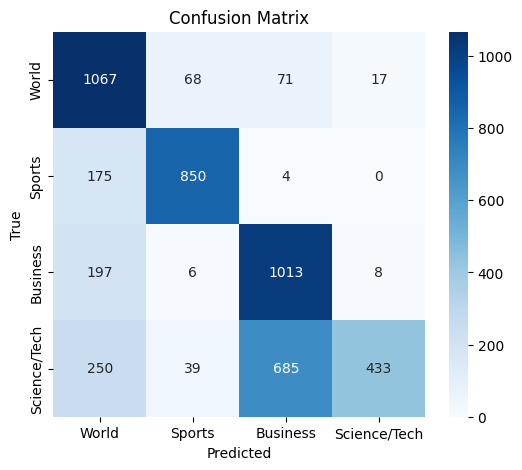

In [111]:
cm = confusion_matrix(y_true, y_pred, labels=list(labels.values()))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels.values(),
            yticklabels=labels.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()